# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

Tabla encontrada, extrayendo datos...

DataFrame creado:
   Year   Revenue  Change
0  2024  $97.69 B   0.95%
1  2023  $96.77 B   18.8%
2  2022  $81.46 B  51.35%
3  2021  $53.82 B  70.67%
4  2020  $31.53 B  28.31%

Valores después de quitar B o M
0     97.69
1     96.77
2     81.46
3     53.82
4     31.53
5     24.57
6     21.46
7     11.75
8      7.00
9      4.04
10     3.19
11     2.01
12     0.41
13     0.20
14     0.11
15     0.11
Name: Revenue, dtype: float64
Index(['Year', 'Revenue', 'Change'], dtype='object')


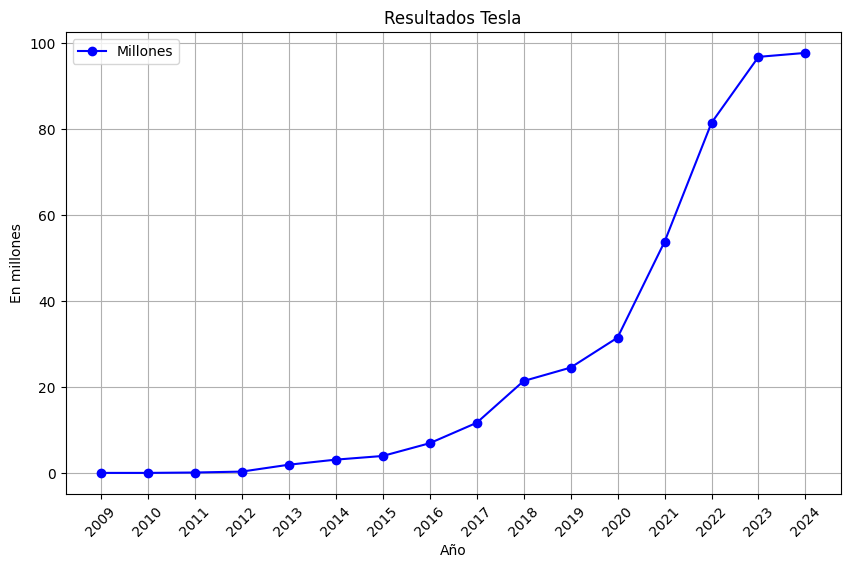

In [32]:

import requests
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

resource_url = "https://companiesmarketcap.com/tesla/revenue"


response = requests.get(resource_url)
if response.status_code != 200:
    raise Exception(f"Error al acceder a la página: {response.status_code}")
html_content = response.text


soup = BeautifulSoup(html_content, 'html.parser')


table = soup.find("table")


if table:
    print("Tabla encontrada, extrayendo datos...")

    rows = table.find_all("tr")
    headers = [th.get_text(strip=True) for th in rows[0].find_all("th")]

    data = []
    for row in rows[1:]:
        row_data = [td.get_text(strip=True) for td in row.find_all("td")]
        data.append(row_data)


    df = pd.DataFrame(data, columns=headers)
    print("\nDataFrame creado:")
    print(df.head())

else:
    raise Exception("No se ha encontrado ninguna tabla en la página")


def convertir_ingresos(valor):
    if isinstance(valor, str):
        valor = valor.replace("$", "").replace(",", "").strip()
        if "B" in valor:
            return float(valor.replace("B", ""))
        elif "M" in valor:
            return float(valor.replace("M", ""))


df["Revenue"] = df["Revenue"].apply(convertir_ingresos)
print("\nValores después de quitar B o M")
print(df["Revenue"])

conn = sqlite3.connect("tesla_resultados.db")
cursor = conn.cursor()
cursor.execute("""
CREATE TABLE IF NOT EXISTS revenue (
    year TEXT,
    revenue REAL
)
""")

print(df.columns)
for index, row in df.iterrows():
    cursor.execute("INSERT INTO revenue (year, revenue) VALUES (?, ?)", (row["Year"], row["Revenue"]))

conn.commit()
conn.close()

df["Year"] = pd.to_datetime(df["Year"], format="%Y")

plt.figure(figsize=(10, 6))
plt.plot(df["Year"], df["Revenue"], marker='o', label="Millones", color='b')

plt.title("Resultados Tesla")
plt.xlabel("Año")
plt.ylabel("En millones")
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend()
plt.grid(True)

plt.show()